# A small 1D pic without Poisson
To try out the fake R model

In [4]:
#import
import numpy as np
import scipy as sp
import astropy
from imp import reload

import matplotlib.pyplot as plt
%matplotlib inline
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

import src

from src.plasma import plasma
from src.particles import particles

from src.functions import generate_maxw, velocity_maxw_flux, max_vect, fux_vect, numba_return_density, smooth

reload(src.plasma)
reload(src.particles)
reload(src.functions)

from ipywidgets import IntProgress as prog
from IPython.display import display
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [5]:
#parameters
Lx = 1e-2 #System length
dX = 1e-5 #dX in m
Nx = int(Lx/dX)+1 #cell number
Lx = Nx*dX
print("Nx = {Nx}, and Lx = {Lx} cm".format(Nx = Nx, Lx = Lx*100))

Npart = 50*Nx #particles number, in particle par cell
n = 1e17  #[m^-3]
dT = 4e-12 #time step
Te = 20;     #[eV] Electron distribution temperature
Ti = 5 #[eV]

me = 9.109e-31; #[kg] electron mass
q = 1.6021765650e-19; #[C] electron charge
kb = 1.3806488e-23;  #Blozman constant
eps_0 = 8.8548782e-12; #Vaccum permitivitty
mi = 131*1.6726219e27 #[kg]

L_De = np.sqrt(eps_0*Te/(q*n))

dT = 1e-10 #time step

Nx = 1000, and Lx = 1.0 cm


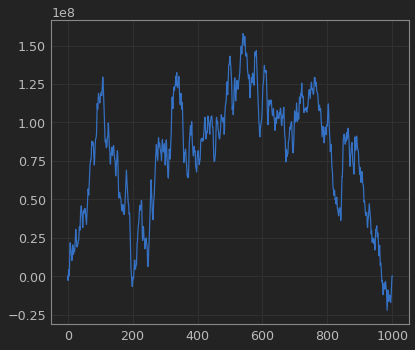

In [7]:
#Generate plasma
pla = plasma(dT,Nx,Lx,Npart,n,Te,Ti)

#fix Electric field profile
#pla.E[:,0] = 45e3*np.exp(-pla.x_j/(5*L_De))
pla.compute_rho()
pla.solve_poisson()
plt.plot(pla.E[:,0])
plt.show()
#plt.plot(pla.rho)
#plt.show()

 0.0 mu s 
*** Profile stats marshalled to file '/tmp/tmphrsr9w43'. 


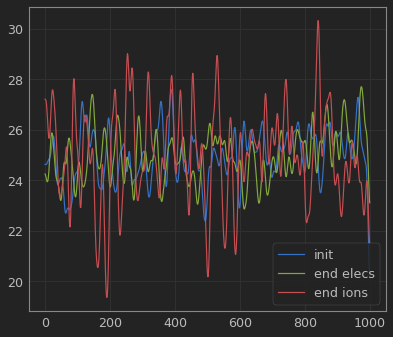

In [8]:
%%snakeviz
Nt = 10
n_av = 100
a = 1.2
pla.compute_rho()
plt.plot(smooth(pla.ne),label = "init");

for nt in np.arange(Nt):
    if nt%10 == 0 : print("\r",nt*pla.dT*1e6,"mu s",end="")
    pla.pusher()
    pla.boundary()
    pla.compute_rho()
    pla.solve_poisson()
    
    #We need to had boundary
    if nt > 1 and nt%n_av ==0:
        ie = pla.history["Ie_c"][-n_av:]
        ii = pla.history["Ii_c"][-n_av:]
        if ie > ii :
            print("\r",nt,"times a",end="")
            #pla.E[:,0] *= a
        else:
            print("\r",nt,"divied by a",end="")
            #pla.E[:,0] /= a
    
plt.plot(smooth(pla.ne),label = "end elecs");
plt.plot(smooth(pla.ni),label = "end ions");

plt.legend()

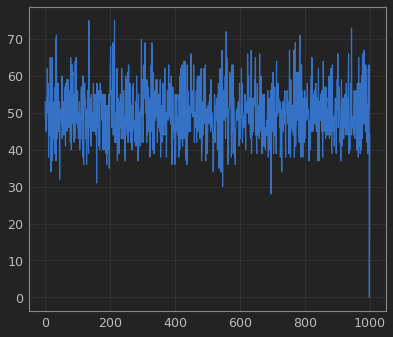

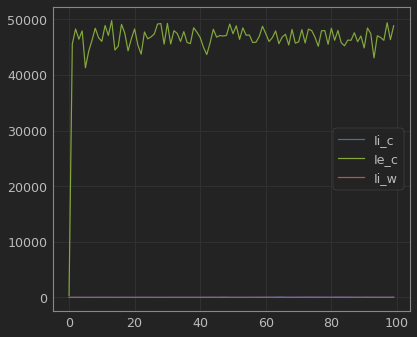

In [15]:
plt.plot(pla.ele.return_density(pla.x_j))
plt.show()

for k in pla.history.keys():
    if k != 'Ie_w':
        plt.plot(pla.history[k],label = k)

plt.legend()

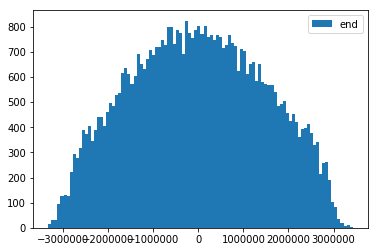

In [22]:
plt.hist(pla.ele.V[:,0],label="end",bins=100);
plt.legend()

In [13]:
pla.compute_rho()
pla.solve_poisson()
print(pla.rho)

[  0.00000000e+00   3.20438219e-19   6.40869092e-19 ...,  -6.40862189e-19
   1.24381196e-24   0.00000000e+00]


In [7]:
di = pla.rho.copy() / 555
diprim = di.copy()
print(diprim)

[  0.00000000e+00   1.12459628e+16   1.12459628e+16 ...,   1.12459628e+16
   1.12459628e+16   0.00000000e+00]


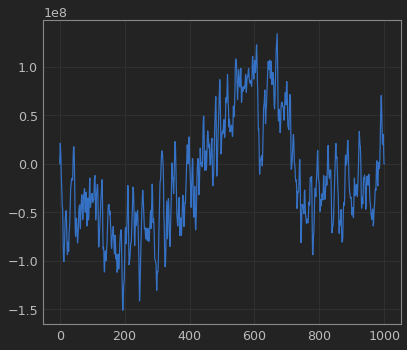

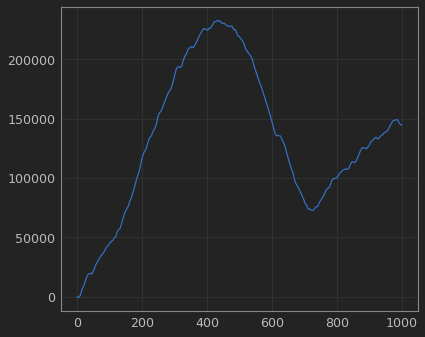

In [19]:
plt.plot(pla.E[:,0])
plt.show()
plt.plot(pla.phi)

In [46]:
print(diprim)
print(pla.bi)
pla.ai[0] = 0.
print(pla.ai)
print(pla.ci)
ciprim = np.copy(pla.ci) #copy the value, not the reference
ciprim[0] /= pla.bi[0]
for i in np.arange(1,len(ciprim)):
    ciprim[i] /= pla.bi[i] - pla.ai[i]*ciprim[i-1]

pla.ciprim = ciprim
print(pla.ciprim)

[ 0.         0.0018018  0.0018018 ...,  0.0018018  0.0018018  0.       ]
[-1. -2. -2. ..., -2. -2. -1.]
[ 0.  1.  1. ...,  1.  1.  1.]
[ 0.  1.  1. ...,  1.  1.  0.]
[-0.         -0.5        -0.66666667 ..., -0.998999   -0.999      -0.        ]


In [47]:
diprim = np.copy(pla.rho)

diprim[0] /= pla.bi[0]
for i in np.arange(1,len(diprim)):
    if pla.ai[i] < 0.5 : print(i)
    diprim[i] -= pla.ai[i]*diprim[i-1]
    diprim[i] /= pla.bi[i] - pla.ai[i]*pla.ciprim[i-1]
    
print(diprim)
pla.phi[0] = 0
pla.phi[-1] = diprim[-1]
#limit conditions
pla.rho[[0,-1]] = 0
for i in np.arange(pla.Nx-1,1,-1):
    pla.phi[i] = diprim[i] - pla.ciprim[i]*pla.phi[i+1]

[ -0.00000000e+00  -5.00000000e-01  -1.00000000e+00 ...,  -4.99000000e+02
  -4.99500000e+02  -4.99500000e+05]


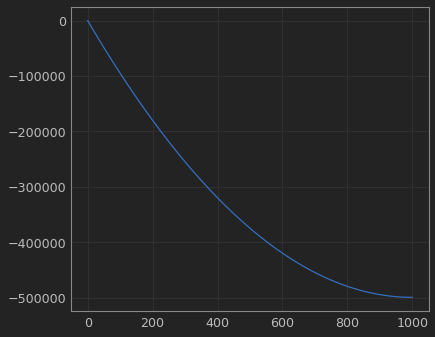

In [48]:
plt.plot(pla.phi)

In [82]:
diprim.copy()

array([ -0.00000000e+00,  -5.00000000e-01,  -1.00000000e+00, ...,
        -4.99000000e+02,  -4.99500000e+02,  -4.99500000e+05])